/tmp/ipykernel_181813/2221916174.py:23: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df.loc[:, 'popularity'] = df['popularity'].astype(float)


Most popular songs and artists by year:
    year               track_name artist_name  popularity
6   1971          She's Got a Way  Billy Joel        52.0
1   1971  Everybody Loves You Now  Billy Joel        41.0
7   1971        Tomorrow Is Today  Billy Joel        33.0
2   1971      Falling of the Rain  Billy Joel        32.0
9   1971             Why Judy Why  Billy Joel        32.0
10  1971     You Can Make Me Free  Billy Joel        32.0
3   1971       Got to Begin Again  Billy Joel        30.0
5   1971                 Nocturne  Billy Joel        30.0
8   1971              Turn Around  Billy Joel        29.0
11  1971   You Look so Good to Me  Billy Joel        29.0


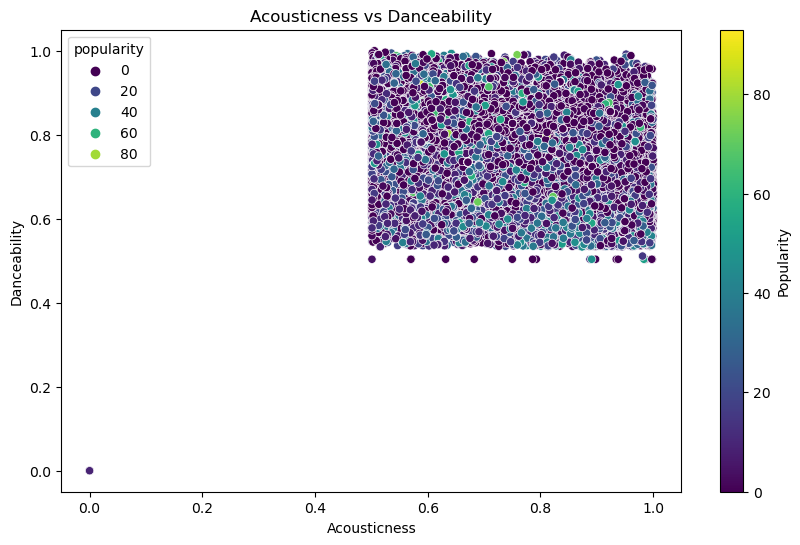

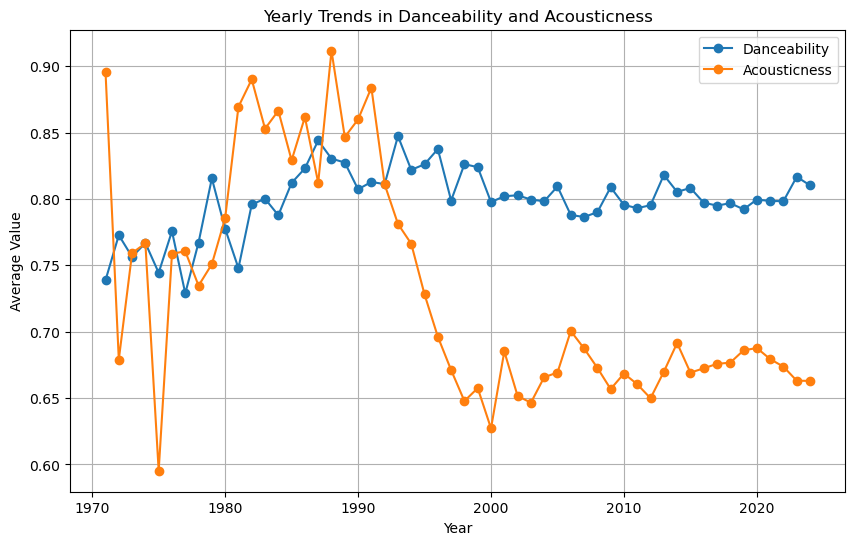

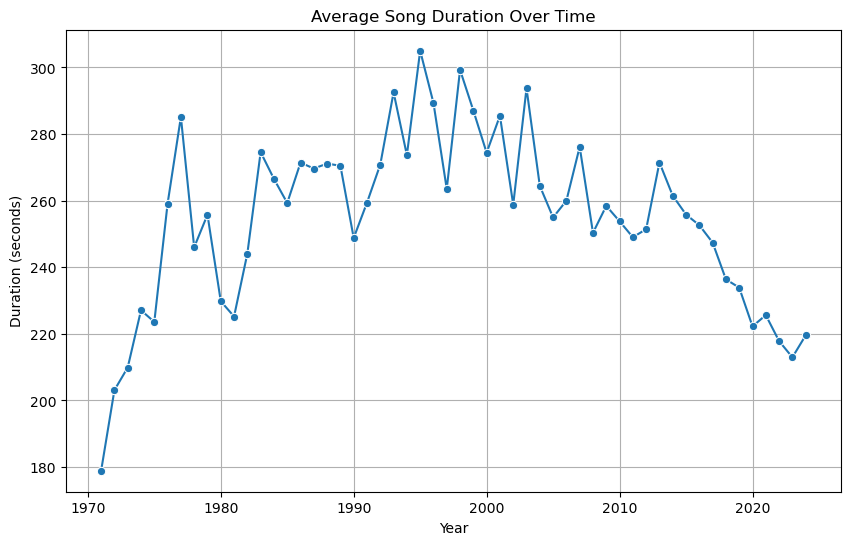

/home/cle-nb-206/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


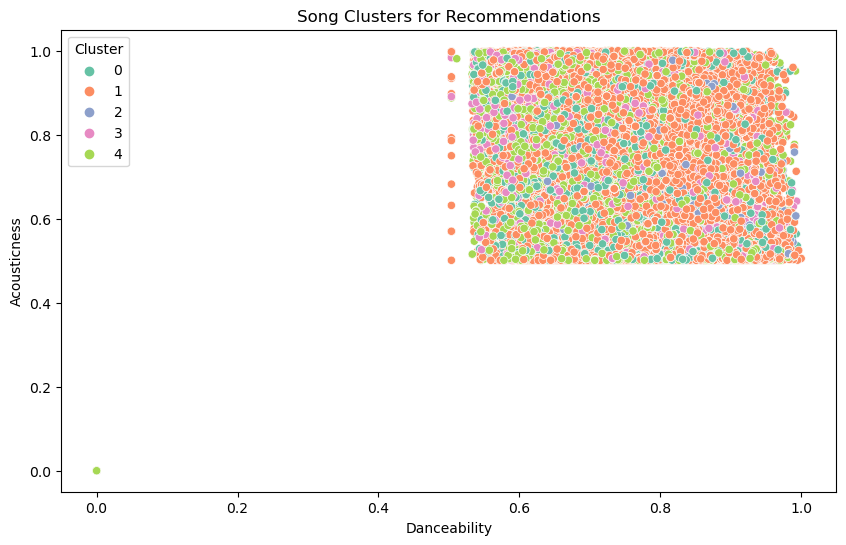

Example recommendations:
                       track_name  \
31247                  Good Bones   
42242                     Purpose   
59960  Loca (feat. Dizzee Rascal)   
24674               Airplane pt.2   
55850                 Barbaadiyan   

                                             artist_name  
31247                                        LE SSERAFIM  
42242                                      Justin Bieber  
59960                             Shakira, Dizzee Rascal  
24674                                                BTS  
55850  Sachet Tandon, Nikhita Gandhi, Madhubanti Bagc...  


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
df = pd.read_csv('spotify_tracks.csv')

# Data Preprocessing
# Data Preprocessing
def preprocess_data(df):
    # Handle missing values
    df = df.dropna(subset=['acousticness', 'danceability', 'energy', 'liveness', 'popularity'])  # Drop rows where essential features are missing

    # Convert 'year' to integer and 'popularity' to float using .loc
    df.loc[:, 'year'] = df['year'].astype(int)
    df.loc[:, 'popularity'] = df['popularity'].astype(float)

    # Create new features
    df.loc[:, 'duration_seconds'] = df['duration_ms'] / 1000
    bins = [0, 33, 66, 100]
    labels = ['Low', 'Medium', 'High']
    df.loc[:, 'popularity_category'] = pd.cut(df['popularity'], bins=bins, labels=labels)

    # Normalize numerical features
    scaler = MinMaxScaler()
    df.loc[:, ['acousticness', 'danceability', 'energy', 'liveness']] = scaler.fit_transform(df[['acousticness', 'danceability', 'energy', 'liveness']])

    # Split multi-artist names
    df.loc[:, 'artist_list'] = df['artist_name'].apply(lambda x: x.split(','))

    # Optional: Create 'decade' feature
    df.loc[:, 'decade'] = (df['year'] // 10) * 10

    return df


# 1. Most Popular Songs/Artists of the Year
def popular_songs_artists(df):
    top_songs = df.groupby(['year', 'track_name', 'artist_name'])['popularity'].mean().reset_index()
    top_songs = top_songs.sort_values(['year', 'popularity'], ascending=[True, False])
    print("Most popular songs and artists by year:")
    print(top_songs.head(10))

# 2. Acoustic vs. Danceable Songs
def acoustic_vs_danceable(df):
    plt.figure(figsize=(10, 6))
    scatter = sns.scatterplot(data=df, x='acousticness', y='danceability', hue='popularity', palette='viridis')
    plt.title('Acousticness vs Danceability')
    plt.xlabel('Acousticness')
    plt.ylabel('Danceability')

    # Create ScalarMappable object for colorbar
    sm = plt.cm.ScalarMappable(cmap='viridis', norm=plt.Normalize(vmin=df['popularity'].min(), vmax=df['popularity'].max()))
    sm.set_array([])  # Set an empty array for ScalarMappable

    # Add colorbar, explicitly passing the current Axes
    plt.colorbar(sm, ax=plt.gca(), label='Popularity')

    plt.show()

# 3. Yearly Trends in Music
def yearly_trends(df):
    trends = df.groupby('year')[['danceability', 'acousticness']].mean().reset_index()
    plt.figure(figsize=(10, 6))
    plt.plot(trends['year'], trends['danceability'], label='Danceability', marker='o')
    plt.plot(trends['year'], trends['acousticness'], label='Acousticness', marker='o')
    plt.title('Yearly Trends in Danceability and Acousticness')
    plt.xlabel('Year')
    plt.ylabel('Average Value')
    plt.legend()
    plt.grid()
    plt.show()

# 4. Song Duration Insights
def song_duration_trends(df):
    duration_trends = df.groupby('year')['duration_ms'].mean().reset_index()
    duration_trends['duration_seconds'] = duration_trends['duration_ms'] / 1000
    plt.figure(figsize=(10, 6))
    sns.lineplot(data=duration_trends, x='year', y='duration_seconds', marker='o')
    plt.title('Average Song Duration Over Time')
    plt.xlabel('Year')
    plt.ylabel('Duration (seconds)')
    plt.grid()
    plt.show()

# 5. Spotify Wrapped Recommendations
def spotify_recommendations(df):
    # Select features for clustering
    features = df[['danceability', 'acousticness', 'popularity']]
    features = features.dropna()

    # Perform clustering
    kmeans = KMeans(n_clusters=5, random_state=42)
    df['cluster'] = kmeans.fit_predict(features)

    # Display clusters
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x='danceability', y='acousticness', hue='cluster', data=df, palette='Set2')
    plt.title('Song Clusters for Recommendations')
    plt.xlabel('Danceability')
    plt.ylabel('Acousticness')
    plt.legend(title='Cluster')
    plt.show()

    # Function to recommend songs from similar clusters
    def recommend_songs(track_id):
        cluster = df.loc[df['track_id'] == track_id, 'cluster'].values[0]
        recommendations = df[df['cluster'] == cluster].sample(5)
        return recommendations[['track_name', 'artist_name']]

    # Example recommendation
    print("Example recommendations:")
    print(recommend_songs(df['track_id'].iloc[0]))

# Preprocess the data
df = preprocess_data(df)

# Call the functions
popular_songs_artists(df)
acoustic_vs_danceable(df)
yearly_trends(df)
song_duration_trends(df)
spotify_recommendations(df)
